In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import TimeDistributed as td
from keras.layers import Input, Conv2D, Flatten, Dense, ZeroPadding2D, Activation, concatenate
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape, UpSampling2D
from keras.models import Model

In [32]:
# Convoltuion blocks
def conv_block(tensor, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    x = Conv2D(filters=nfilters, kernel_size=(size,size) , padding=padding, kernel_initializer = 'he_normal')(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def deconv_block(tensor, residual, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    y = UpSampling2D(size = (2,2))(tensor)
    y = Conv2D(filters=nfilters, kernel_size=(size,size), activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(y)
    y = concatenate([y,residual], axis = 3)
    y = conv_block(y, nfilters)

    return y


In [33]:
def get_jnet():
    inputs = Input((224,224,3))

    #Contraction path
    conv1= conv_block(inputs, 16)
    pool1 = MaxPooling2D(pool_size=2)(conv1)

    conv2 = conv_block(pool1, 32)
    pool2 = MaxPooling2D(pool_size=2)(conv2)

    conv3 = conv_block(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 128)
    pool4 = MaxPooling2D(pool_size=2)(conv4)

    conv5 = conv_block(pool4, 256)

    #Expansion path
    up6 = deconv_block(conv5, conv4, 128)
    up7 = deconv_block(up6, conv3, 64)
    up8 = deconv_block(up7, conv2, 32)
    up9= deconv_block(up8, conv1, 16)

    pool_fin = MaxPooling2D(pool_size=2)(up9)
    conv10 = Conv2D(16, kernel_size=(28, 28), strides=(28, 28))(pool_fin)
    out = BatchNormalization()(conv10)
    out = Reshape((16, 16))(out)
    out = Activation('softmax')(out)

    model = Model(inputs=[inputs], outputs=[out])

    return model

In [34]:
model = get_jnet()
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [35]:
def load_data(base_path, path, pieces=2):
    data = pd.read_csv(base_path + '{}.csv'.format(path))
    path = base_path + path + '/'

    x, y = [], []
    for i in range(len(data)):
        im = Image.open(path + str(i) + '.jpg')
        im = np.array(im).astype('float16')
        im = im / 255 - 0.5

        x.append(im)

        label = data.iloc[i]
        label = [int(i) for i in label]
        y.append(label)

    return (np.array(x), np.expand_dims(np.array(y), axis=-1))

In [36]:
def group_image(images, shuffle_arr, pieces=4):
  img = []

  new_array = [shuffle_arr[i] for i in shuffle_arr]
  print(new_array)
  new_order =  [images[i] for i in new_array]

  for i in range(pieces):
    img.append(np.concatenate(new_order[i*pieces:(i+1)*pieces], axis=1))

  img = np.concatenate(img, axis=0)
  return img

In [37]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
base_path = "/content/drive/My Drive/puzzle_4x4/"

In [39]:
!ls


drive  puzzle_4x4.hdf5	sample_data


In [40]:
x_train, y_train = load_data(base_path, 'train', pieces=4)

In [41]:
x_val, y_val = load_data(base_path, 'valid', pieces=4)

In [42]:
weightpath = "best_weights.hdf5"
checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks=callbacks_list)

filepath="puzzle_4x4.hdf5"
model.save(filepath)

Epoch 1/50
12/13 [==========================>...] - ETA: 0s - loss: 2.4552 - sparse_categorical_accuracy: 0.2446

13/13 [==============================] - 12s 475ms/step - loss: 2.4549 - sparse_categorical_accuracy: 0.2448 - val_loss: 2.6606 - val_sparse_categorical_accuracy: 0.1682
Epoch 2/50
12/13 [==========================>...] - ETA: 0s - loss: 1.6969 - sparse_categorical_accuracy: 0.5525

13/13 [==============================] - 5s 409ms/step - loss: 1.6971 - sparse_categorical_accuracy: 0.5524 - val_loss: 2.6322 - val_sparse_categorical_accuracy: 0.1858
Epoch 3/50
12/13 [==========================>...] - ETA: 0s - loss: 1.2347 - sparse_categorical_accuracy: 0.7644

13/13 [==============================] - 5s 411ms/step - loss: 1.2350 - sparse_categorical_accuracy: 0.7641 - val_loss: 2.5798 - val_sparse_categorical_accuracy: 0.2011
Epoch 4/50
12/13 [==========================>...] - ETA: 0s - loss: 0.9163 - sparse_categorical_accuracy: 0.8805

13/13 [==============================] - 5s 415ms/step - loss: 0.9156 - sparse_categorical_accuracy: 0.8808 - val_loss: 2.5010 - val_sparse_categorical_accuracy: 0.2392
Epoch 5/50
12/13 [==========================>...] - ETA: 0s - loss: 0.6875 - sparse_categorical_accuracy: 0.9369

13/13 [==============================] - 5s 400ms/step - loss: 0.6884 - sparse_categorical_accuracy: 0.9367 - val_loss: 2.3918 - val_sparse_categorical_accuracy: 0.2494
Epoch 6/50
12/13 [==========================>...] - ETA: 0s - loss: 0.5744 - sparse_categorical_accuracy: 0.9557

13/13 [==============================] - 5s 394ms/step - loss: 0.5746 - sparse_categorical_accuracy: 0.9558 - val_loss: 2.3459 - val_sparse_categorical_accuracy: 0.2659
Epoch 7/50
12/13 [==========================>...] - ETA: 0s - loss: 0.4789 - sparse_categorical_accuracy: 0.9675

13/13 [==============================] - 5s 394ms/step - loss: 0.4790 - sparse_categorical_accuracy: 0.9676 - val_loss: 2.2619 - val_sparse_categorical_accuracy: 0.3420
Epoch 8/50
12/13 [==========================>...] - ETA: 0s - loss: 0.4264 - sparse_categorical_accuracy: 0.9786

13/13 [==============================] - 5s 384ms/step - loss: 0.4277 - sparse_categorical_accuracy: 0.9783 - val_loss: 2.1509 - val_sparse_categorical_accuracy: 0.4960
Epoch 9/50
12/13 [==========================>...] - ETA: 0s - loss: 0.4130 - sparse_categorical_accuracy: 0.9819

13/13 [==============================] - 5s 387ms/step - loss: 0.4138 - sparse_categorical_accuracy: 0.9817 - val_loss: 2.0550 - val_sparse_categorical_accuracy: 0.5358
Epoch 10/50
12/13 [==========================>...] - ETA: 0s - loss: 0.4015 - sparse_categorical_accuracy: 0.9822

13/13 [==============================] - 5s 397ms/step - loss: 0.4020 - sparse_categorical_accuracy: 0.9821 - val_loss: 1.9253 - val_sparse_categorical_accuracy: 0.6261
Epoch 11/50
12/13 [==========================>...] - ETA: 0s - loss: 0.3633 - sparse_categorical_accuracy: 0.9825

13/13 [==============================] - 5s 380ms/step - loss: 0.3635 - sparse_categorical_accuracy: 0.9825 - val_loss: 1.8521 - val_sparse_categorical_accuracy: 0.6278
Epoch 12/50
12/13 [==========================>...] - ETA: 0s - loss: 0.3213 - sparse_categorical_accuracy: 0.9861

13/13 [==============================] - 5s 384ms/step - loss: 0.3214 - sparse_categorical_accuracy: 0.9861 - val_loss: 1.7491 - val_sparse_categorical_accuracy: 0.6511
Epoch 13/50
12/13 [==========================>...] - ETA: 0s - loss: 0.2765 - sparse_categorical_accuracy: 0.9897

13/13 [==============================] - 5s 388ms/step - loss: 0.2764 - sparse_categorical_accuracy: 0.9898 - val_loss: 1.6267 - val_sparse_categorical_accuracy: 0.7193
Epoch 14/50
12/13 [==========================>...] - ETA: 0s - loss: 0.2383 - sparse_categorical_accuracy: 0.9931

13/13 [==============================] - 5s 387ms/step - loss: 0.2384 - sparse_categorical_accuracy: 0.9931 - val_loss: 1.4936 - val_sparse_categorical_accuracy: 0.7886
Epoch 15/50
12/13 [==========================>...] - ETA: 0s - loss: 0.2206 - sparse_categorical_accuracy: 0.9941

13/13 [==============================] - 5s 392ms/step - loss: 0.2208 - sparse_categorical_accuracy: 0.9941 - val_loss: 1.3765 - val_sparse_categorical_accuracy: 0.8438
Epoch 16/50
12/13 [==========================>...] - ETA: 0s - loss: 0.2116 - sparse_categorical_accuracy: 0.9965

13/13 [==============================] - 5s 398ms/step - loss: 0.2116 - sparse_categorical_accuracy: 0.9965 - val_loss: 1.3280 - val_sparse_categorical_accuracy: 0.8369
Epoch 17/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1899 - sparse_categorical_accuracy: 0.9962

13/13 [==============================] - 5s 392ms/step - loss: 0.1902 - sparse_categorical_accuracy: 0.9962 - val_loss: 1.1932 - val_sparse_categorical_accuracy: 0.9011
Epoch 18/50
12/13 [==========================>...] - ETA: 0s - loss: 0.2034 - sparse_categorical_accuracy: 0.9945

13/13 [==============================] - 5s 398ms/step - loss: 0.2041 - sparse_categorical_accuracy: 0.9944 - val_loss: 1.2212 - val_sparse_categorical_accuracy: 0.7369
Epoch 19/50
12/13 [==========================>...] - ETA: 0s - loss: 0.2096 - sparse_categorical_accuracy: 0.9929

13/13 [==============================] - 5s 395ms/step - loss: 0.2098 - sparse_categorical_accuracy: 0.9929 - val_loss: 1.1315 - val_sparse_categorical_accuracy: 0.8205
Epoch 20/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1987 - sparse_categorical_accuracy: 0.9945

13/13 [==============================] - 5s 388ms/step - loss: 0.1990 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.9185 - val_sparse_categorical_accuracy: 0.9216
Epoch 21/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1952 - sparse_categorical_accuracy: 0.9945

13/13 [==============================] - 5s 397ms/step - loss: 0.1955 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.8860 - val_sparse_categorical_accuracy: 0.8977
Epoch 22/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1776 - sparse_categorical_accuracy: 0.9972

13/13 [==============================] - 5s 390ms/step - loss: 0.1778 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.7017 - val_sparse_categorical_accuracy: 0.9648
Epoch 23/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1631 - sparse_categorical_accuracy: 0.9977

13/13 [==============================] - 5s 389ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.6030 - val_sparse_categorical_accuracy: 0.9773
Epoch 24/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1491 - sparse_categorical_accuracy: 0.9987

13/13 [==============================] - 5s 400ms/step - loss: 0.1498 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.5261 - val_sparse_categorical_accuracy: 0.9807
Epoch 25/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1649 - sparse_categorical_accuracy: 0.9973

13/13 [==============================] - 5s 394ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.5164 - val_sparse_categorical_accuracy: 0.9790
Epoch 26/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1464 - sparse_categorical_accuracy: 0.9981

13/13 [==============================] - 5s 404ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.4408 - val_sparse_categorical_accuracy: 0.9795
Epoch 27/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1306 - sparse_categorical_accuracy: 0.9990

13/13 [==============================] - 5s 397ms/step - loss: 0.1307 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.3985 - val_sparse_categorical_accuracy: 0.9869
Epoch 28/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1222 - sparse_categorical_accuracy: 0.9996

13/13 [==============================] - 5s 392ms/step - loss: 0.1224 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.3287 - val_sparse_categorical_accuracy: 0.9852
Epoch 29/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1162 - sparse_categorical_accuracy: 0.9993

13/13 [==============================] - 5s 392ms/step - loss: 0.1165 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.2899 - val_sparse_categorical_accuracy: 0.9881
Epoch 30/50
13/13 [==============================] - ETA: 0s - loss: 0.1312 - sparse_categorical_accuracy: 0.9978

13/13 [==============================] - 5s 402ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.3543 - val_sparse_categorical_accuracy: 0.9761
Epoch 31/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1126 - sparse_categorical_accuracy: 0.9993

13/13 [==============================] - 5s 384ms/step - loss: 0.1126 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.2492 - val_sparse_categorical_accuracy: 0.9881
Epoch 32/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1016 - sparse_categorical_accuracy: 0.9997

13/13 [==============================] - 5s 385ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.2325 - val_sparse_categorical_accuracy: 0.9915
Epoch 33/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0939 - sparse_categorical_accuracy: 0.9998

13/13 [==============================] - 5s 398ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.2008 - val_sparse_categorical_accuracy: 0.9886
Epoch 34/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0884 - sparse_categorical_accuracy: 0.9998

13/13 [==============================] - 5s 391ms/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.1984 - val_sparse_categorical_accuracy: 0.9909
Epoch 35/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1108 - sparse_categorical_accuracy: 0.9994

13/13 [==============================] - 5s 391ms/step - loss: 0.1108 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.2092 - val_sparse_categorical_accuracy: 0.9807
Epoch 36/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1061 - sparse_categorical_accuracy: 0.9993

13/13 [==============================] - 5s 392ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.1903 - val_sparse_categorical_accuracy: 0.9875
Epoch 37/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1960 - sparse_categorical_accuracy: 0.9958

13/13 [==============================] - 5s 386ms/step - loss: 0.1959 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.3330 - val_sparse_categorical_accuracy: 0.9591
Epoch 38/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1511 - sparse_categorical_accuracy: 0.9980

13/13 [==============================] - 5s 389ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.2475 - val_sparse_categorical_accuracy: 0.9835
Epoch 39/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1534 - sparse_categorical_accuracy: 0.9943

13/13 [==============================] - 5s 398ms/step - loss: 0.1534 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.2803 - val_sparse_categorical_accuracy: 0.9653
Epoch 40/50
12/13 [==========================>...] - ETA: 0s - loss: 0.1174 - sparse_categorical_accuracy: 0.9979

13/13 [==============================] - 5s 393ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.1640 - val_sparse_categorical_accuracy: 0.9881
Epoch 41/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0979 - sparse_categorical_accuracy: 0.9993

13/13 [==============================] - 5s 391ms/step - loss: 0.0980 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.1223 - val_sparse_categorical_accuracy: 0.9943
Epoch 42/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0847 - sparse_categorical_accuracy: 0.9995

13/13 [==============================] - 5s 393ms/step - loss: 0.0850 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.1124 - val_sparse_categorical_accuracy: 0.9955
Epoch 43/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0836 - sparse_categorical_accuracy: 0.9995

13/13 [==============================] - 5s 393ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.1185 - val_sparse_categorical_accuracy: 0.9920
Epoch 44/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0778 - sparse_categorical_accuracy: 0.9998

13/13 [==============================] - 5s 394ms/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0992 - val_sparse_categorical_accuracy: 0.9937
Epoch 45/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0722 - sparse_categorical_accuracy: 0.9996

13/13 [==============================] - 5s 392ms/step - loss: 0.0722 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.1164 - val_sparse_categorical_accuracy: 0.9932
Epoch 46/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0677 - sparse_categorical_accuracy: 0.9996

13/13 [==============================] - 5s 387ms/step - loss: 0.0679 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.0910 - val_sparse_categorical_accuracy: 0.9955
Epoch 47/50
13/13 [==============================] - ETA: 0s - loss: 0.0664 - sparse_categorical_accuracy: 1.0000

13/13 [==============================] - 5s 394ms/step - loss: 0.0664 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0978 - val_sparse_categorical_accuracy: 0.9932
Epoch 48/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0709 - sparse_categorical_accuracy: 0.9999

13/13 [==============================] - 5s 392ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.1072 - val_sparse_categorical_accuracy: 0.9949
Epoch 49/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0771 - sparse_categorical_accuracy: 0.9994

13/13 [==============================] - 5s 388ms/step - loss: 0.0775 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.1252 - val_sparse_categorical_accuracy: 0.9903
Epoch 50/50
12/13 [==========================>...] - ETA: 0s - loss: 0.0828 - sparse_categorical_accuracy: 0.9993

13/13 [==============================] - 5s 389ms/step - loss: 0.0829 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.1818 - val_sparse_categorical_accuracy: 0.9824


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss                               0.082888
sparse_categorical_accuracy        0.999269
val_loss                           0.181837
val_sparse_categorical_accuracy    0.982386
dtype: float64

In [44]:
def plot_loss_accuraccy(history):
    history_df = pd.DataFrame(history.history)
    print("Maximum accuracy: {}".format(history_df['val_sparse_categorical_accuracy'].max()))
    history_df[['loss', 'val_loss']].plot()
    history_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

Maximum accuracy: 0.9954545497894287


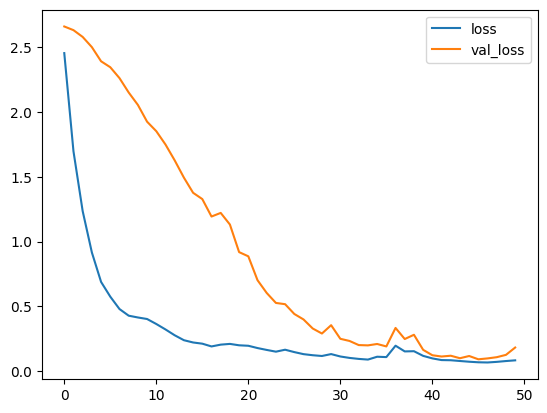

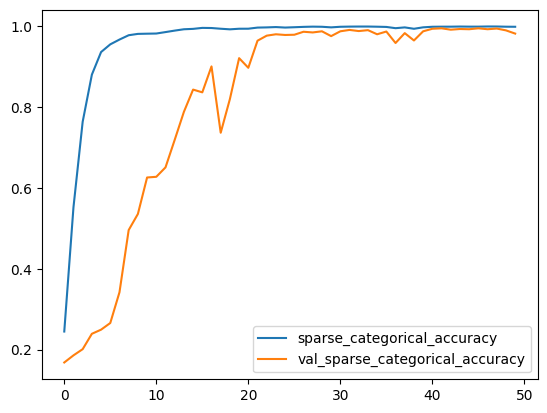

In [45]:
plot_loss_accuraccy(history)

## Test model

In [46]:
model = keras.models.load_model('puzzle_4x4.hdf5')

In [47]:
pieces=4

x_test, y_test = load_data(base_path, 'test', pieces=pieces)

In [48]:
y_pred = model.predict(x_test)
predict = [np.argmax(y, axis=1) for y in y_pred]
accuracy = np.mean(keras.metrics.categorical_accuracy(y_test.reshape(-1, 4*4), predict))

print("Accuracy on {} samples: {}%".format(len(y_pred), accuracy*100))

4/4 [==============================] - 1s 71ms/step
Accuracy on 110 samples: 93.63636374473572%


In [49]:
def rearrange(im, label, pieces=4, dim=224, channel=3):
    cut_len = dim // pieces

    new_im = np.zeros((dim, dim, channel))
    for i in range(pieces):

        hor_cut = im[i * cut_len:(i + 1) * cut_len]

        for j in range(pieces):
            piece = hor_cut[:, j * cut_len:(j + 1) * cut_len]

            pos = label[i * pieces + j]
            x = pos // pieces
            y = pos % pieces

            new_im[x * cut_len:(x + 1) * cut_len, y * cut_len:(y + 1) * cut_len] = piece

    return new_im

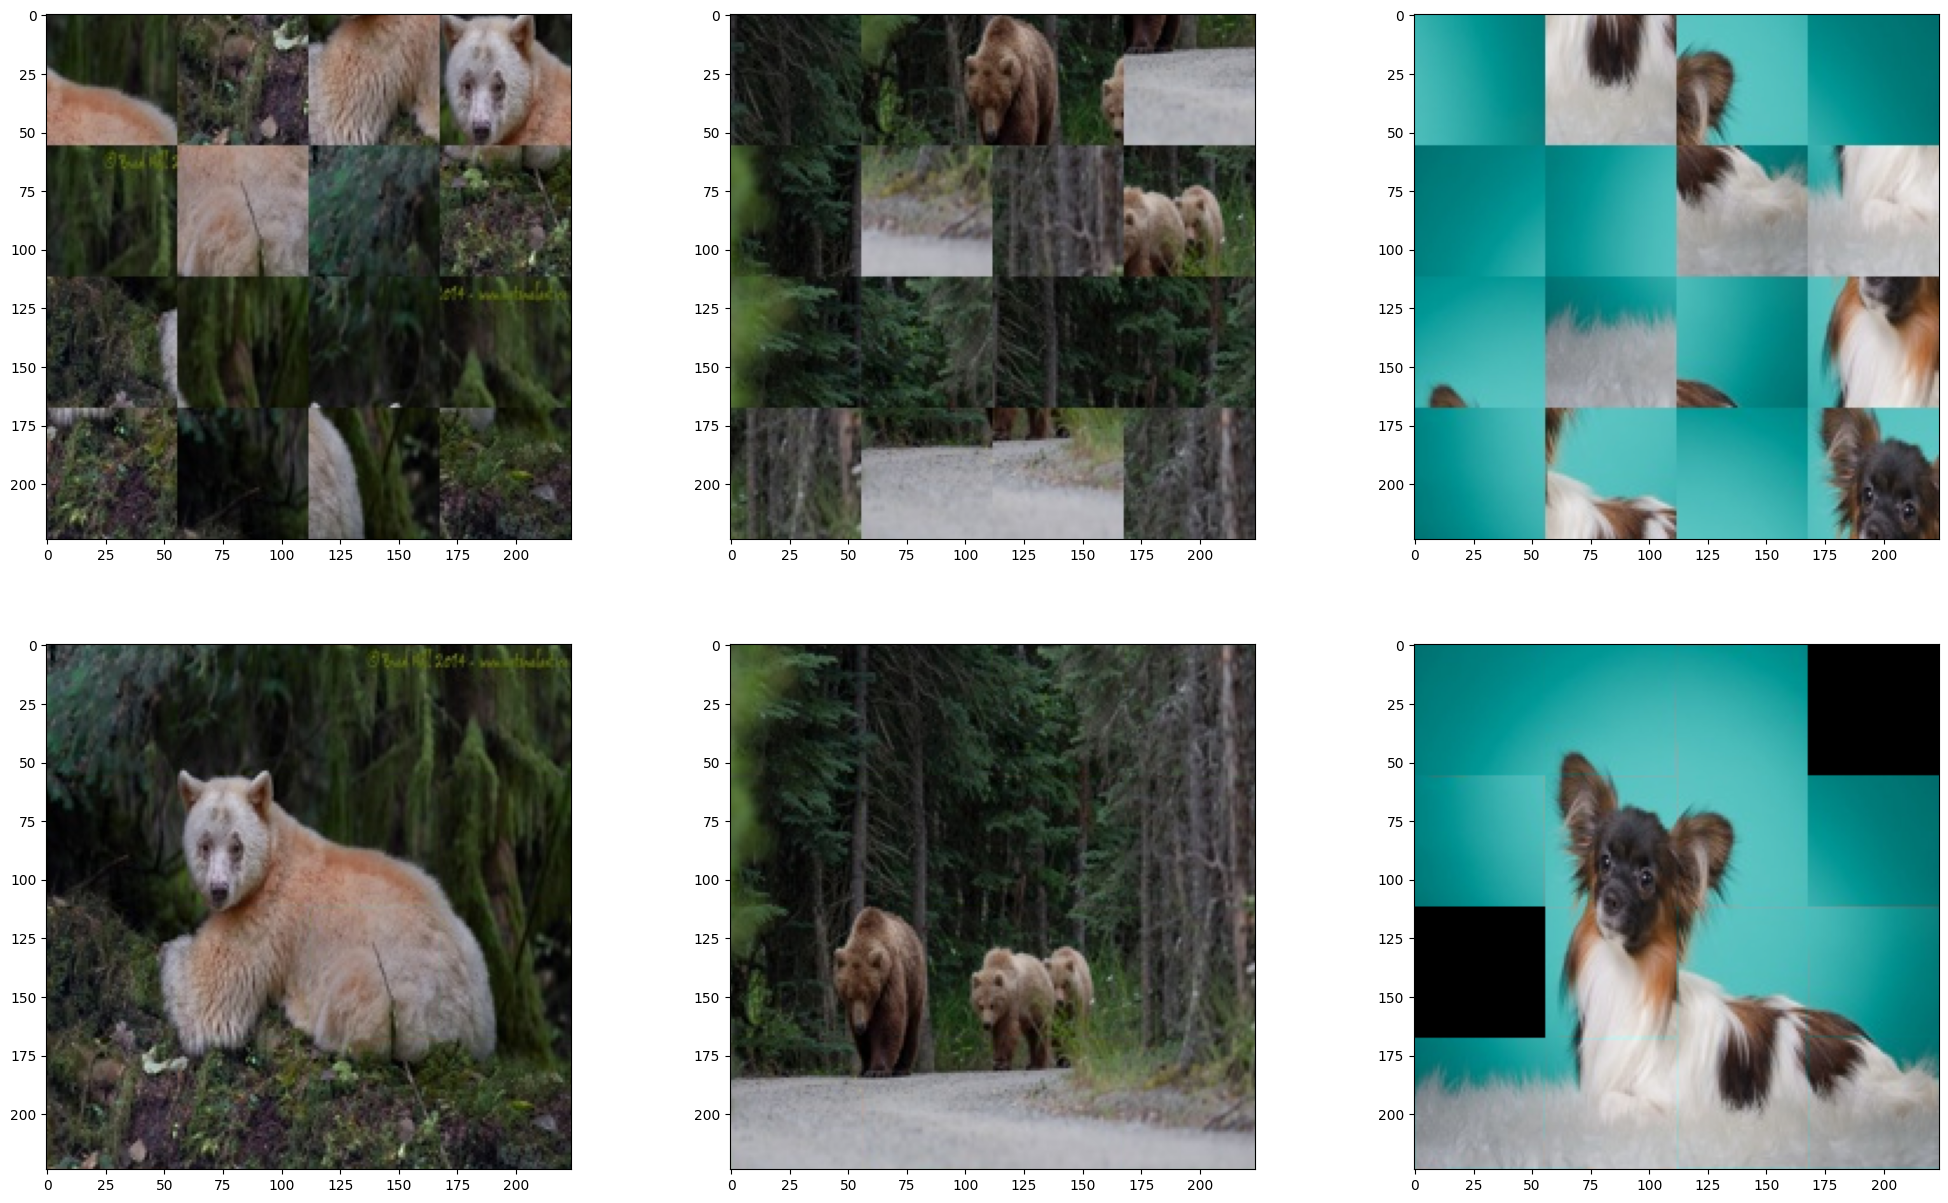

In [50]:
fig, ax = plt.subplots(2, 3, figsize=(25, 15))
indexes = np.random.randint(len(x_test), size=3)

for i, idx in enumerate(indexes):
    image = x_test[idx].astype('float64')+.5
    ax[0, i].imshow(image)

    y_pred_idx = np.argmax(y_pred[idx], axis=1)
    arrange_img = rearrange(image, y_pred_idx)
    ax[1, i].imshow(arrange_img)
